<a href="https://colab.research.google.com/github/eh1k4ri/pose-estimation/blob/main/AnimalPoseEstimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Faça a implementação do pose estimation para bovinos, seguindo as etapas abaixo e registrando seus resultados no README.md de um repositório GitHub no seu usuário Inteli:
1 - Obtenha o dataset ANIMAL-POSE DATASET (https://sites.google.com/view/animal-pose/) e faça uma análise exploratória, de forma a apresentar gráficos, suas descrições textuais e destacar quantas imagens do dataset são de bovinos;
2 - Faça a filtragem do dataset para que somente imagens de bovinos sejam processados, e descreva as etapas de processamento de imagem realizados por meio de uma figura ilustrativa do processo e um exemplo detalhado passo-a-passo;
3 - Apresente os resultados finais do processamento feito com gráficos/tabelas e suas descrições textuais, de forma a resumir os principais resultados obtidos;
4 - Apresente suas conclusões pessoais em uma seção final do README.md, destacando os principais aprendizados, as limitações do trabalho e sugestões de trabalhos futuros
Envie o link do repositório GitHub com as 4 seções solicitadas no README.md, e o código da implementação realizada em notebook Python (arquivo IPYNB).

# 1. Análise Exploratória


## Importando o dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Análise Exploratória

### Importações

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np

In [ ]:
pip install roboflow ultralytics

### Criando um data frame pra facilitar a manipulação das imagens

In [ ]:
image_folder = '/content/drive/MyDrive/archive/images/images'

image_files = os.listdir(image_folder)

df_images = pd.DataFrame(image_files, columns=['name'])

df_images.head()


,name
0,2007_001225.jpg
1,2007_001185.jpg
2,2007_000925.jpg
3,2007_001073.jpg
4,2007_000799.jpg


In [ ]:
bovinos = df_images[df_images['name'].str.startswith('co')]

bovinos_count = bovinos.shape[0]
total_images = df_images.shape[0]

print(f"Total de imagens: {total_images}")
print(f"Imagens categorizadas de bovinos: {bovinos_count}")


Total de imagens: 4608
Imagens categorizadas de bovinos: 200


In [ ]:
df_images.describe()

,name
count,4608
unique,4608
top,2007_001225.jpg
freq,1


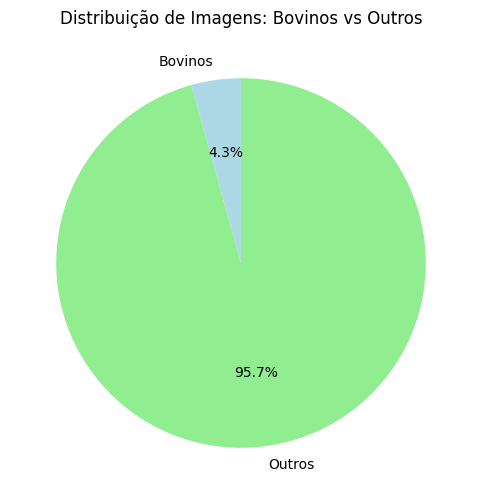

In [ ]:
labels = ['Bovinos', 'Outros']
counts = [bovinos_count, total_images - bovinos_count]

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen'])
plt.title('Distribuição de Imagens: Bovinos vs Outros')
plt.show()

In [ ]:
image_files = os.listdir(image_folder)

df_images = pd.DataFrame(image_files, columns=['name'])
df_images = df_images[df_images['name'].str[0].str.isalpha()]

df_images['animals'] = df_images['name'].str[:2].str.lower()

df_images.head()

,name,animals
3590,ca109.jpeg,ca
3591,ca106.jpeg,ca
3592,ca108.jpeg,ca
3593,ca107.jpeg,ca
3594,ca104.jpeg,ca


In [ ]:
category_counts = df_images['animals'].value_counts()

category_counts.head()

,count
animals,
ca,200
co,200
do,200
ho,200
sh,200


In [3]:
categories = {
    'ca': 'cat',
    'co': 'cow',
    'do': 'dog',
    'ho': 'horse',
    'sh': 'sheep'
}

image_files = os.listdir(image_folder)

data = []

for image_file in image_files:
    prefix = image_file[:2]

    if prefix in categories:
        data.append(categories[prefix])

df = pd.DataFrame(data, columns=['category'])

category_counts = df['category'].value_counts()

print(category_counts)

plt.figure(figsize=(8, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.title('Contagem de Imagens por Categoria')
plt.xlabel('Categoria')
plt.ylabel('Número de Imagens')
plt.show()


NameError: name 'image_folder' is not defined

## 2. Filtragem, processamento e modelo

### Filtragem

In [ ]:
bovine_images = []

for image_file in image_files:

    prefix = image_file[:2]

    if prefix == 'co':
        bovine_images.append(image_file)

df_bovine = pd.DataFrame(bovine_images, columns=['image_name'])

df_bovine.head()

,image_name
0,co10.jpeg
1,co1.jpeg
2,co123.jpeg
3,co120.jpeg
4,co121.jpeg


## Processamento das imagens com redimensionamento, filtro em escala cinza e converão para NumPy array

In [1]:

# Função para processar a imagem
def process_image(image_path, size=(128, 128)):
    # Carregar a imagem
    img = Image.open(image_path)

    # Redimensionar a imagem
    img = img.resize(size)

    # Converter para escala de cinza (opcional)
    img = img.convert("L")  # "L" significa modo de escala de cinza

    # Converter para array NumPy e normalizar os valores (0 a 1)
    img_array = np.array(img) / 255.0

    return img_array

# Exemplo de processamento de uma imagem
image_path = '/mnt/data/images/cow_image.jpg'
processed_image = process_image(image_path)

# Mostrar a imagem original e a imagem processada
plt.figure(figsize=(12, 6))

# Imagem original
plt.subplot(1, 2, 1)
original_image = Image.open(image_path)
plt.imshow(original_image)
plt.title("Imagem Original")

# Imagem processada
plt.subplot(1, 2, 2)
plt.imshow(processed_image, cmap='gray')
plt.title("Imagem Processada (128x128, Escala de Cinza)")

plt.show()


NameError: name 'os' is not defined

### Conversão do Json de keypoints para labels yolo

In [ ]:
import json
import os

# Caminho do arquivo JSON e da pasta de imagens
json_path = '/mnt/data/keypoints.json'
image_folder = '/mnt/data/images'
yolo_labels_folder = '/mnt/data/labels'

# Criar a pasta para os arquivos de anotações no formato YOLO
if not os.path.exists(yolo_labels_folder):
    os.makedirs(yolo_labels_folder)

# Carregar o arquivo JSON com as anotações de keypoints
with open(json_path, 'r') as f:
    annotations = json.load(f)

# Exemplo de como os keypoints estão organizados
# Supondo que as chaves 'annotations' e 'keypoints' existam no JSON

for image_id, image_name in annotations['images'].items():
    # Caminho do arquivo de anotação YOLO para esta imagem
    label_file_path = os.path.join(yolo_labels_folder, image_name.replace('.jpg', '.txt'))

    # Abrir o arquivo de anotação YOLO para escrever
    with open(label_file_path, 'w') as label_file:
        for annotation in annotations['annotations']:
            if annotation['image_id'] == image_id:
                # Obter as coordenadas dos keypoints
                keypoints = annotation['keypoints']

                # Converter os keypoints para o formato YOLO (normalizados)
                # Supondo que os keypoints venham em pares (x, y)
                for i in range(0, len(keypoints), 2):
                    x = keypoints[i] / image_info['width']
                    y = keypoints[i + 1] / image_info['height']
                    label_file.write(f"{x} {y}\n")


## Treinando o modelo

## 3. Resultados

## 4. Para acessar a documentação desse projeto acesse:
https://github.com/eh1k4ri/pose-estimation